# Landfall decay rates for tropical cyclones in the Australian region

This notebook analyses the historical best track data from [IBTrACS](http://www.ncdc.noaa.gov/oa/ibtracs/) to evaluate the rate of decay of cyclones after landfall. 

In previous studies (e.g. Vickery, 2005), the rate of change of central pressure deficit ($\Delta p_c$) after landfall is modelled as an exponential decay function:

$\Delta p_c(t) = \Delta p_0 e^{(-\alpha t)}$

where $\alpha = \alpha_0 + \alpha_1 \Delta p_0$ and $\Delta p_0$ is the central pressure deficit at landfall. The decay rate $\alpha$ may also be a function of the translation speed after landfall ($v_t$) and the radius to maxium winds ($R_{max}$). 

Here, we are attempting to fit this model to TC occurrences in the Australian region. Records of $R_{max}$ in the Australian region are limited, so this relationship is not explored. 

In [1]:
%matplotlib inline

from __future__ import print_function

import sys
import numpy as np
import pandas as pd

from scipy.optimize import leastsq
import io

from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from mpl_toolkits.basemap import Basemap

from Utilities.loadData import loadTrackFile
from Utilities.config import ConfigParser
from Utilities.track import Track

import seaborn
seaborn.set_context("poster")

Define the configuration settings for the analysis. You will need to have the latest version of the IBTrACS data and the daily long term mean sea level pressure data stored locally. Modify the path to those files as required.

To modify the region analysed, change the `gridLimit` option in the `Region` section. You can restrict the TC seasons used by modifying the `StartSeason` option in the `DataProcess` section. 

In [16]:
configstr = """
[DataProcess]
InputFile=C:/WorkSpace/data/TC/Allstorms.ibtracs_wmo.v03r06.csv
Source=IBTRACS
StartSeason=1981
FilterSeasons=True

[Region]
; Domain for windfield and hazard calculation
gridLimit={'xMin':108.,'xMax':156.,'yMin':-28.0,'yMax':-9.0}
gridSpace={'x':1.0,'y':1.0}
gridInc={'x':1.0,'y':0.5}

[Input]
landmask = C:/WorkSpace/tcrm/input/landmask.nc
mslpfile = C:/WorkSpace/data/MSLP/slp.day.ltm.nc
datasets = IBTRACS,LTMSLP

[IBTRACS]
; Input data file settings
url = ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r06/wmo/csv/Allstorms.ibtracs_wmo.v03r06.csv.gz
path = C:/WorkSpace/data/TC/
filename = Allstorms.ibtracs_wmo.v03r06.csv
columns = tcserialno,season,num,skip,skip,skip,date,skip,lat,lon,skip,pressure
fielddelimiter = ,
numberofheadinglines = 3
pressureunits = hPa
lengthunits = km
dateformat = %Y-%m-%d %H:%M:%S
speedunits = kph

[LTMSLP]
; MSLP climatology file settings
URL = ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/surface/slp.day.1981-2010.ltm.nc
path = C:/WorkSpace/data/MSLP
filename = slp.day.ltm.nc
"""

Load the configuration settings from the string representation above. Normally, this would be stored in a file and read directly from there. 

In [17]:
config = ConfigParser()
config.readfp(io.BytesIO(configstr))

Load the track file. This reports the number of tracks loaded - this varies based on the `StartSeason` option in the `DataProcess` section above. Tracks for all basins are loaded by default, and then we filter spatially at a later step.

In [18]:
trackFile = config.get('DataProcess', 'InputFile')
source = config.get('DataProcess', 'Source')

print("Track file: {0}".format(trackFile))
print("Track format: {0}".format(source))
tracks = loadTrackFile(configstr, trackFile, source)
print("There are {0:d} tracks in the input dataset".format(len(tracks)))

Track file: C:/WorkSpace/data/TC/Allstorms.ibtracs_wmo.v03r06.csv
Track format: IBTRACS
There are 3061 tracks in the input dataset


Set up a map to define the study region. I have to set up different keyword arguments for `Basemap` for plotting using `saveTrackMap`, because it cannot use a cylindrical projection (it baulks at setting up a scale bar). And we can't use a Mercator projection in the map used for testing if TCs are on land or not. 

In [19]:
domain = config.geteval('Region', 'gridLimit')
mapkwargs = dict(llcrnrlon=domain['xMin'],
                 llcrnrlat=domain['yMin'],
                 urcrnrlon=domain['xMax'],
                 urcrnrlat=domain['yMax'],
                 resolution='c',
                 projection='cyl')
m = Basemap(**mapkwargs)


This function identifies the landfall pressure deficit and time, then extracts the pressure deficit at all times after landfall.

It returns the initial pressure deficit $\Delta p_{0}$, the pressure deficit $\Delta p_c (t)$ at each subsequent point in time, and the time after landfall $t$ (in hours). Only those storms where there are at least two observations _after landfall_ are returned. 

Presently, the function returns once a valid storm is found and either ends or moves offshore. This misses the second or later landfalls of those storms that make multiple landfalls. 

In [20]:
def processTrack(track, m):
    onland = np.zeros(len(track.Longitude))
    dp0 = 0
    v0 = 0
    for i, (lon, lat) in enumerate(zip(track.Longitude, 
                                      track.Latitude)):
        if m.is_land(lon, lat):
            onland[i] = 1

    dp = []
    dt = []
    v = []
    flag = 0
    for i in range(1, len(onland)):
        if (onland[i]==1) & (onland[i-1]==0) & (track.CentralPressure[i-1] > 0.0):
            # New landfall (with central pressure prior to landfall):
            t0 = track.TimeElapsed[i-1]
            dp0 = track.EnvPressure[i-1] - track.CentralPressure[i-1]
            v0 = track.Speed[i-1]
            flag = 1
        
        if (flag==1) & (track.CentralPressure[i] > 0.0):
            # Storm is on land and has a valid central pressure record:
            dp.append(track.EnvPressure[i] - track.CentralPressure[i])
            dt.append(track.TimeElapsed[i] - t0)
            v.append(track.Speed[i])
            flag = onland[i]
            if flag == 0:
                return dp0, dp, dt, v0, np.mean(np.array(v))
    if len(dp) > 1:
        return dp0, dp, dt, v0, np.mean(np.array(v))
    else:
        return None, None, None, None, None
        

Define a pair of functions to fit the pressure deficit (as a function of time after landfall) to an exponential decay model. The `minimise` function returns the $\alpha$ parameter for an event.

In [21]:
def residuals(params, dp, dt, dp0):
    yfit = dp0 * np.exp(-(np.array(params) * dt))
    return dp - yfit

def minimise(dp, dt, dp0, alpha=0., beta=1.):
    plsq = leastsq(residuals, [alpha], args=(dp, dt, dp0))
    return plsq[0]

Cycle through all the tracks in the input dataset. If the track passes through the study region, then we will process it to obtain the decay rate as a function of $\Delta p_0$ and $t$. The fitted decay rate is added to a list of values, as is the landfall pressure value. We exclude those events where the pressure deficit after landfall exceeds the pressure deficit prior to landfall (i.e. $\Delta p(t \neq 0) > \Delta p_0$). 

The time history of each event is then plotted -- both the central pressure deficit ($\Delta p_c(t)$) and the central pressure deficit normalised by the landfall pressure deficit ($\Delta p_0$).

In [22]:
def plotEvent(ax, dt, dp, dp0, params):
    ax.scatter(dt, dp/dp0, marker='s')
    xt = ax.get_xticks()
    ax.set_xlabel("Time after landfall (hours)")
    ax.set_xticks(range(0,12*int(1+max(xt)/12.+1),12))
    ax.set_ylabel(r"$\frac{\Delta p_c(t)}{\Delta p_0}$ (hPa)")
    xm = np.linspace(0, 12*int(max(dt)/12.), 100)    
    ax.set_xlim((0,12*int(1+max(xt)/12.)))

    legtext = r"$\Delta p_c = \Delta p_0 \exp{(%f t)}$"%(-params[0])
    ym = np.exp(-params[0]*xm)
    ax.plot(xm, ym, label=legtext)
    (ymin, ymax) = ax.get_ylim()
    l = ax.legend(loc=0)
    ax.set_ylim((0,ymax))

If you want to plot individual tracks and the fitted decay model, uncomment the lines in the innermost if-clause. 

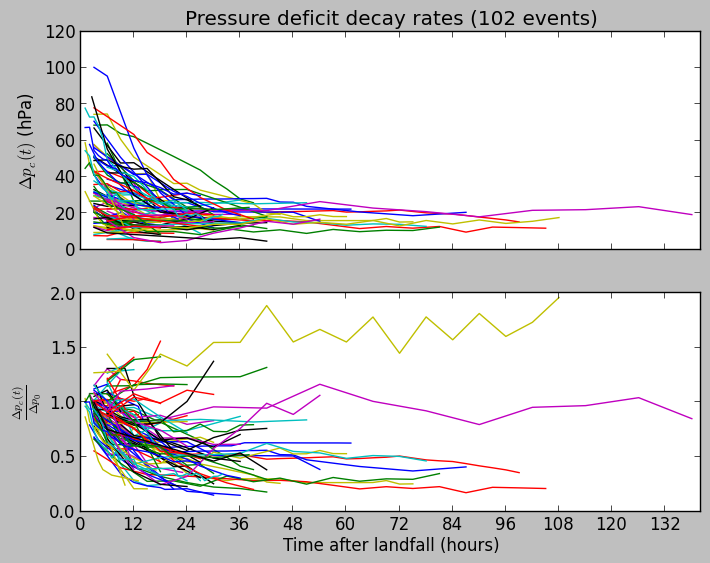

In [23]:
landfall_pressure = []
landfall_speed = []
decayrate = []
lftracks = []
nevents=0
fig1, (ax1, ax2) = plt.subplots(2,1,sharex=True)

for n, track in enumerate(tracks):
    if track.inRegion(domain):
        # Process the track to get the pressure at landfall and the decay rate thereafter:
        dp0, dp, dt, v0, v = processTrack(track, m)
        if (dp0 is not None): # and (dp0 > max(dp)):
            nevents += 1
            lftracks.append(track)
            p = minimise(dp, dt, dp0, 0., 1.)
            ax1.plot(dt, dp)
            ax2.plot(dt, (dp/dp0))
            #fig0, ax = plt.subplots(1,1,sharex=True)
            #plotEvent(ax, dt, dp, dp0, p)
            #ax.set_title("Storm {0} ({1}) ".format(n, track.Year[0]))
            #plt.savefig("{0:03d}.png".format(n))

            decayrate.append(p[0])
            landfall_pressure.append(dp0)
            landfall_speed.append(v)
    
ax2.set_xlabel("Time after landfall (hours)")
xt = ax2.get_xticks()
ax2.set_xticks(range(0,12*int(1+max(xt)/12.),12))
ax1.set_ylabel("$\Delta p_c(t) $ (hPa)")
ax1.set_title("Pressure deficit decay rates ({0} events)".format(nevents))
ax2.set_ylabel(r"$\frac{\Delta p_c(t)}{\Delta p_0}$")


Now fit the decay rate $\alpha$ as a linear model of landfall pressure deficit $\Delta p_0$. The `seaborn.jointplot()` command fits a linear regression to the data, and adds the 95% approximate confidence interval (shaded), based on bootstrap resampling. 

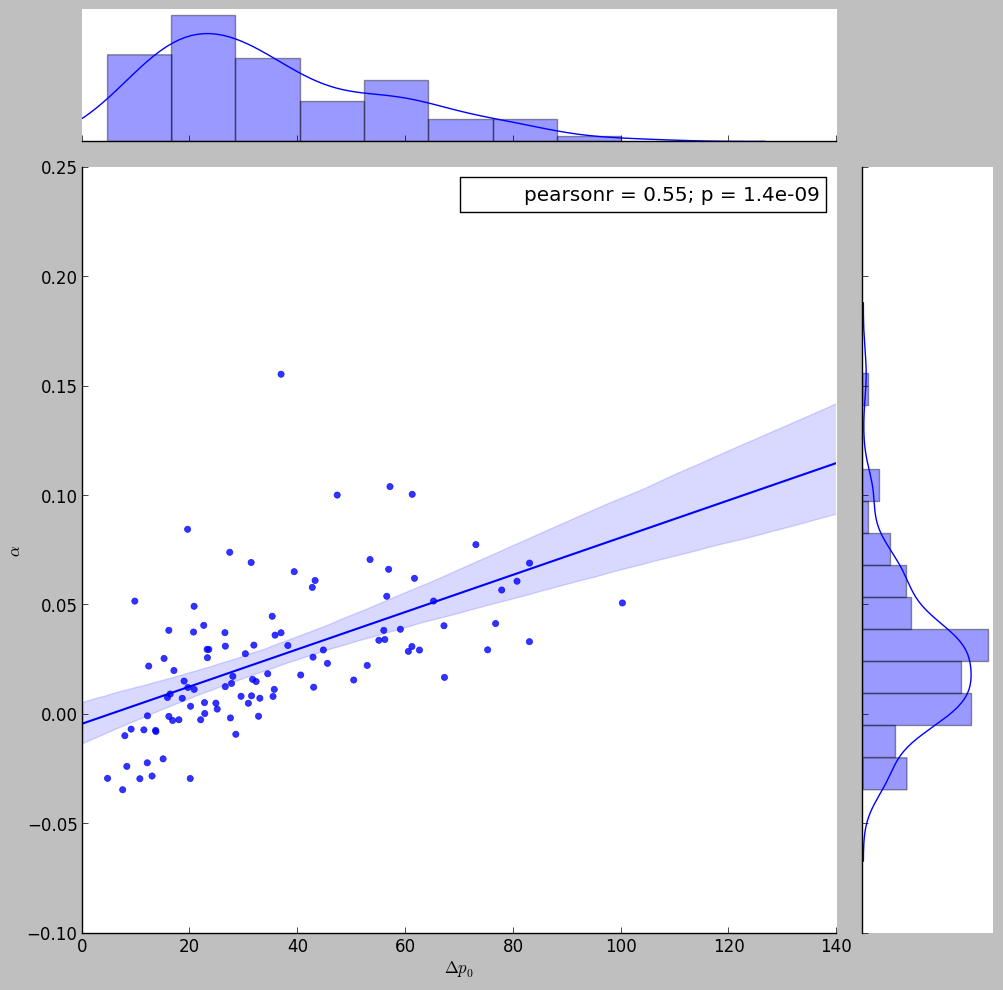

In [24]:
df = pd.DataFrame({'alpha':decayrate,
                   'dp0':landfall_pressure,
                   'v0':landfall_speed})
jp = seaborn.jointplot('dp0','alpha',df, kind='reg', size=10,xlim=(0,140))
jp.set_axis_labels(r"${\Delta p_0}$", r"$\alpha$")

Use [`statmodels`](http://statsmodels.sourceforge.net/) to fit our model of landfall decay rate, as a function of landfalling pressure deficit. 

In [25]:
import statsmodels.api as sm
X = sm.add_constant(landfall_pressure)
y = np.array(decayrate)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
print('Parameters: ', results.params)
print('R2: ', results.rsquared)
print('P-value: ', results.pvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     44.50
Date:                Wed, 22 Apr 2015   Prob (F-statistic):           1.42e-09
Time:                        11:49:06   Log-Likelihood:                 224.93
No. Observations:                 102   AIC:                            -445.9
Df Residuals:                     100   BIC:                            -440.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0040      0.005     -0.769      0.4

But what about the translation speed? Vickery (2005) suggests that translation speed may influence the decay rate. So we plot the average translation speed after landfall ($v_t$) against $\Delta p_0$, with contours of $\alpha$. 

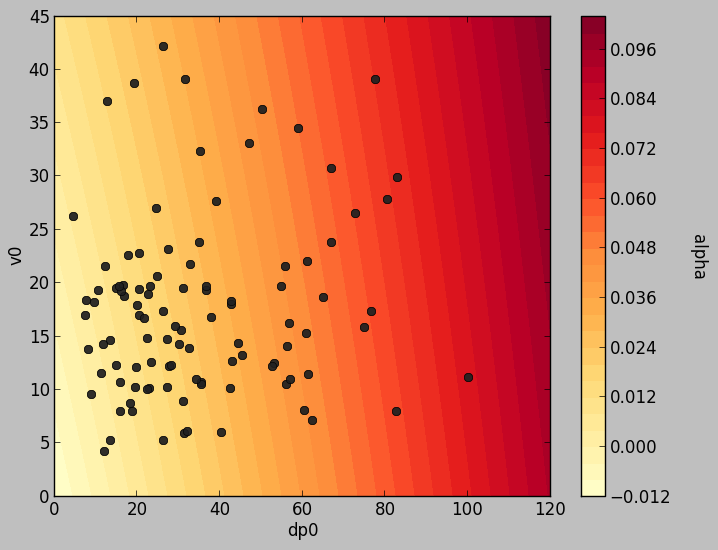

In [26]:
seaborn.interactplot("dp0", 'v0', 'alpha', df, cmap=get_cmap("YlOrRd"), filled=True)

So it appears that there may be a relationship between $\alpha$ and $v_t$. To confirm this, we put together a linear model of $\alpha = f(\Delta p_0, v_t)$. The resulting fit indicates a marginal improvement in the $R^2$ value, and the AIC score is very slightly decreased.

In [27]:
X = np.column_stack((landfall_pressure, landfall_speed))
X = sm.add_constant(X)
y = np.array(decayrate)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
print('Parameters: ', results.params)
print('R2: ', results.rsquared)
print('P-value: ', results.pvalues)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     23.19
Date:                Wed, 22 Apr 2015   Prob (F-statistic):           5.49e-09
Time:                        11:49:09   Log-Likelihood:                 225.75
No. Observations:                 102   AIC:                            -445.5
Df Residuals:                      99   BIC:                            -437.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0104      0.007     -1.434      0.1

Notice that this model does permit a negative rate parameter (see the 95th percentile value for the intercept). i.e. it's possible that the central pressure will increase with time after landfall. This is feasible, since there are many observed TCs that record increases in intensity after landfall. 

Finally, plot the tracks of all landfalling TCs used in the analysis. This uses some code written for [TCRM](https://github.com/GeoscienceAustralia/tcrm), so you'll need to have the code somewhere on the `PYTHONPATH` to get this to work. Notice also this is actually saving the image to a file, then displaying that image file, as opposed to the previous plots which are displayed inline. 

In [28]:
from NoteBookFinder import NotebookFinder
sys.meta_path.append(NotebookFinder())

from TrackMaps import SingleTrackMap, saveTrackMap
from IPython.display import Image

def plotTracks(tracks, domain, source, imgfile):
    fig = SingleTrackMap()
    xx = np.arange(domain['xMin'], domain['xMax']+0.1,0.1)
    yy = np.arange(domain['yMin'], domain['yMax']+0.1,0.1)

    [xgrid, ygrid] = np.meshgrid(xx,yy)
    title = source
    mapkwargs = dict(llcrnrlon=domain['xMin'],
                     llcrnrlat=domain['yMin'],
                     urcrnrlon=domain['xMax'],
                     urcrnrlat=domain['yMax'],
                     resolution='f',
                     projection='merc')
    fig.plot(tracks, xgrid, ygrid, title, mapkwargs)
    saveTrackMap(tracks, xgrid, ygrid, title, mapkwargs, imgfile)


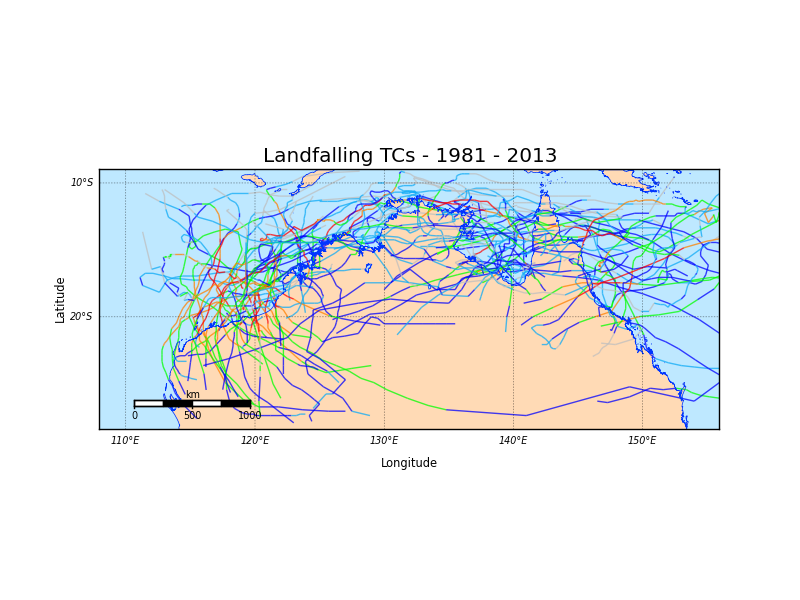

In [29]:
startSeason = config.get("DataProcess", "StartSeason")
plotTracks(lftracks, domain, "Landfalling TCs - {0} - 2013".format(startSeason), "landfallTracks.png")
Image(filename="landfallTracks.png")

This document was written in an IPython notebook. The raw notebook can be downloaded [here](https://github.com/wcarthur/notebooks/blob/master/TC%20landfall%20decay.ipynb). See also [nbviewer](http://nbviewer.ipython.org/github/wcarthur/notebooks/blob/master/TC%20landfall%20decay.ipynb) for an online static view.